In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
from IPython import display

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:04, 5772299.26it/s]                              


Extracting Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to Datasets/FashionMNIST/FashionMNIST/raw


32768it [00:00, 307438.06it/s]                           
0it [00:00, ?it/s]

Extracting Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Datasets/FashionMNIST/FashionMNIST/raw


4423680it [00:00, 5126923.36it/s]                             
8192it [00:00, 128282.65it/s]


Extracting Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Datasets/FashionMNIST/FashionMNIST/raw
Extracting Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [14]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    display.set_matplotlib_formats('svg')
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

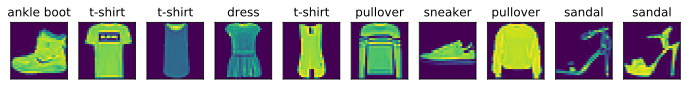

In [15]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])

show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [18]:
batch_size = 256

if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4
    
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [19]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

1.64 sec


In [20]:
import numpy as np

In [21]:
num_inputs = 28 * 28
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [22]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [23]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

In [24]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [25]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()



In [27]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [26]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

In [37]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    
    for epoch in range(num_epochs):
        
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        
        for X, y in train_iter:
            
            y_hat = net(X)
            
            l = loss(y_hat, y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            
            n += y.shape[0]
            
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
            
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)
                

epoch 1, loss 0.5011, train acc 0.832, test acc 0.823
epoch 2, loss 0.4851, train acc 0.837, test acc 0.825
epoch 3, loss 0.4743, train acc 0.840, test acc 0.825
epoch 4, loss 0.4648, train acc 0.843, test acc 0.829
epoch 5, loss 0.4583, train acc 0.845, test acc 0.833


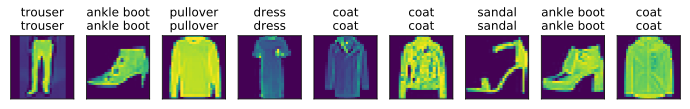

In [42]:

X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())

titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])